In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, train_test_split

import matplotlib.pyplot as plt

In [2]:
# games = pd.read_csv('./gamedata.csv')
games = pd.read_csv('./data/gamedata.csv')

In [4]:
games.to_csv()

0         1408990866000
1         1408994459000
2         1408998197000
3         1409002158000
4         1409600757000
              ...      
404707    1679988841485
404708    1679989636748
404709    1679990274253
404710    1679991086238
404711    1679992870208
Name: timestamp, Length: 404712, dtype: int64

In [4]:
games.shape

(404712, 9)

In [5]:
games.columns

Index(['timestamp', 'player1', 'player2', 'player3', 'player4', 'score1',
       'score2', 'score3', 'score4'],
      dtype='object')

In [6]:
player_cols = ['player1', 'player2', 'player3', 'player4']
score_cols = ['score1','score2','score3','score4']

In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404712 entries, 0 to 404711
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   timestamp  404712 non-null  int64
 1   player1    404712 non-null  int64
 2   player2    404712 non-null  int64
 3   player3    404712 non-null  int64
 4   player4    404712 non-null  int64
 5   score1     404712 non-null  int64
 6   score2     404712 non-null  int64
 7   score3     404712 non-null  int64
 8   score4     404712 non-null  int64
dtypes: int64(9)
memory usage: 27.8 MB


### Player slot victory distribution

In [8]:
print(len(pd.unique(games['player1'].values.flatten())))
print(len(pd.unique(games['player2'].values.flatten())))
print(len(pd.unique(games['player3'].values.flatten())))
print(len(pd.unique(games['player4'].values.flatten())))

8968
8830
8944
8943


This is odd, but not terribly surprising (mostly just statistically unlikely). This says that there are players who have played _strictly_ as player 1 or player 3 or player X (which might not be surprising if someone only plays once or twice). So as weird as this is, it can effectively be ignored since those players probably didn't play many games.

### Unique Players

In [9]:
all_players = pd.Series(pd.unique(games[player_cols].values.flatten()))
len(all_players)

14298

Does more experience automatically mean you become a better player?

Does your win percentage monotonically increase (with some smoothing) with games played?

Can you predict the winner based solely off games played?

How can we compare players with highly differing `play_count`s? Slope of win percentage.

In [10]:
games['winning_score'] = games[score_cols].max(axis=1)

## Players DataFrame (plays, wins, ratio)

In [11]:
play_counts_dict = Counter(games[player_cols].values.flatten())
play_counts = pd.DataFrame.from_dict(play_counts_dict, orient='index', columns=['played_games'])
play_counts.index.name = 'player_id'
play_counts

,played_games
player_id,
7,370
12,375
10,148
6,290
23,175
...,...
33558,2
16990,3
33574,2


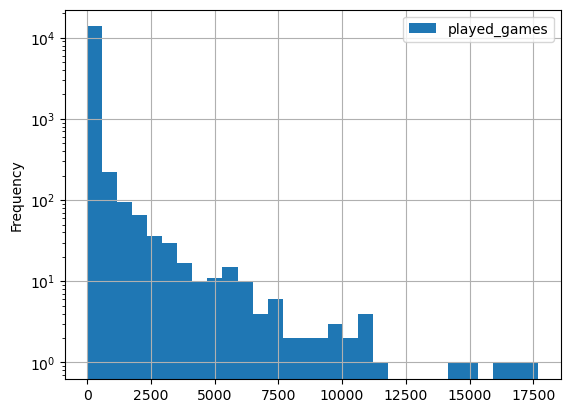

In [12]:
ax = play_counts.plot.hist(bins=30, log=True)
ax.grid()
ax.figure.savefig('./figures/played_games_histogram.png')

This is remarkably balanced since there are about 10,000 users who played just a few games, and a few players with 10,000+ games played. However, the nature of the community lends itself to "noisy" reasons for there to be so many low-play users that are totally unrelated to our root research question (e.g., the 'quitting' problem, trying new strategies, 'straw-man' users, and of course, smack talk).

In [13]:
games['winning_player'] = pd.to_numeric(games[score_cols].idxmax(axis=1).str[-1]).astype('int')
games

,timestamp,player1,player2,player3,player4,score1,score2,score3,score4,winning_score,winning_player
0,1408990866000,7,12,10,6,262,459,406,409,459,2
1,1408994459000,6,12,10,7,524,419,195,402,524,1
2,1408998197000,7,10,6,12,308,353,467,497,497,4
3,1409002158000,12,7,10,6,500,525,256,261,525,2
4,1409600757000,10,6,23,7,383,375,228,242,383,1
...,...,...,...,...,...,...,...,...,...,...,...
404707,1679988841485,32457,32258,21605,12428,384,430,267,537,537,4
404708,1679989636748,736,32258,21605,12254,397,314,404,357,404,3
404709,1679990274253,725,21605,30100,736,275,468,317,237,468,2
404710,1679991086238,725,736,32258,30100,511,337,491,254,511,1


In [14]:
c = Counter(games.winning_player)

In [15]:
bias = pd.DataFrame(c, index=[0])
bias = bias/len(games)
bias = bias[[1,2,3,4]]
bias

,1,2,3,4
0,0.270891,0.260054,0.241601,0.227453


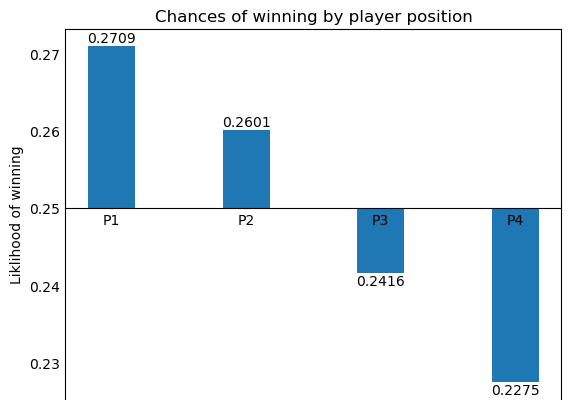

In [16]:
N = 4
biases = np.array(bias)[0]
ii = np.arange(N)
width = 0.35
bottom = 0.25
p1 = plt.bar(ii, biases-bottom, width, bottom=bottom)
plt.ylabel('Liklihood of winning')
plt.title('Chances of winning by player position')
plt.xticks(ii, ('P1', 'P2', 'P3', 'P4'))
plt.tick_params(axis='both', length=0)
ax = plt.gca()
ax.spines['bottom'].set_position(('data', bottom))

for i, b in zip(ii, biases):
    ax.text(i, b, f'{round(b, 4)}\n' if b >= bottom \
            else f'\n{round(b, 4)}', ha='center', va='center')

plt.savefig('./figures/bias.png')
plt.show();

In [17]:
condlist = [
    games['winning_player'] == 1,
    games['winning_player'] == 2,
    games['winning_player'] == 3,
    games['winning_player'] == 4,
]
choices = [
    games['player1'],
    games['player2'],
    games['player3'],
    games['player4'],
]
games['winner_id'] = np.select(condlist, choices, -1)

In [18]:
len(Counter(games.winner_id))

6904

In [19]:
win_counts_dict = Counter(games.winner_id)
win_counts = pd.DataFrame.from_dict(win_counts_dict, orient='index', columns=['won_games'])
# win_counts.hist(bins=30, log=True)

In [20]:
win_ratio_dict = {player: (win_counts_dict[player]/play_counts_dict[player]) for player in all_players}
win_ratios = pd.DataFrame.from_dict(win_ratio_dict, orient='index', columns=['win_ratio'])
# win_ratios.hist(bins=30, log=True)

In [21]:
players = pd.concat([play_counts, win_counts, win_ratios], axis=1)
players.won_games.fillna(0, inplace=True);

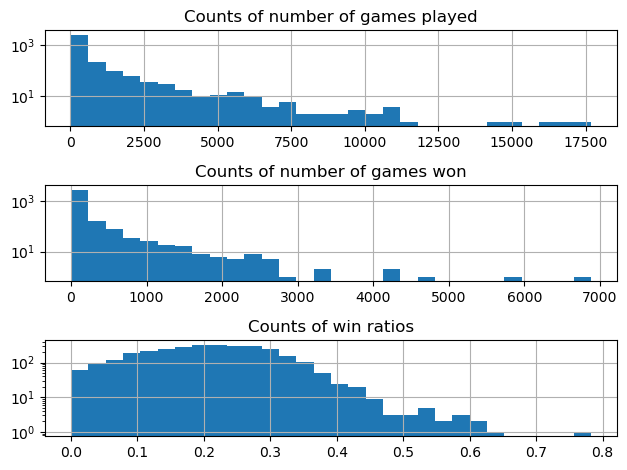

In [22]:
plz = players[players['played_games'] > 20]

fig, axes = plt.subplots(nrows=3, ncols=1)
ax0, ax1, ax2 = axes.flatten()
nbins = 30

ax0.hist(plz.played_games, nbins, log=True)
ax0.set_title('Counts of number of games played')
ax0.grid()

ax1.hist(plz.won_games, nbins, log=True)
ax1.set_title('Counts of number of games won')
ax1.grid()

ax2.hist(plz.win_ratio, nbins, log=True)
ax2.set_title('Counts of win ratios')
ax2.grid()

fig.tight_layout()
fig.savefig("./figures/games_counts.png")
plt.show()

In [23]:
sum(plz.win_ratio > 0.6)

4

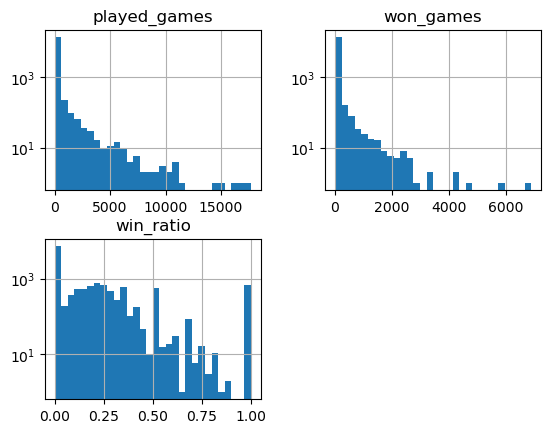

In [24]:
players.hist(bins=30, log=True);

In [25]:
players[(players['win_ratio'] > 0.5) & (players['win_ratio'] < 0.99)]

,played_games,won_games,win_ratio
299,15,8.0,0.533333
316,5,3.0,0.600000
564,10,6.0,0.600000
682,3,2.0,0.666667
743,3,2.0,0.666667
...,...,...,...
32460,9,5.0,0.555556
32476,7,4.0,0.571429
33149,4,3.0,0.750000
33168,3,2.0,0.666667


In [26]:
players.describe()

,played_games,won_games,win_ratio
count,14298.000000,14298.000000,14298.000000
mean,113.221989,28.305497,0.158641
std,648.714019,181.393303,0.242615
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,15.000000,3.000000,0.250000
max,17689.000000,6883.000000,1.000000


In [27]:
sum(players.played_games > 5000)

59

In [83]:
sum((players.won_games == 0) & (players.played_games > 20))

43

In [28]:
# player_indexes = players.sample(4000).index
player_indexes = players.index

In [29]:
# for storing:
#   win count
#   win ratio
player_factors = {}

In [30]:
for p in player_indexes:
    this_players_games = games.query(f'player1 == {p} or \
                                       player2 == {p} or \
                                       player3 == {p} or \
                                       player4 == {p}')
    if len(this_players_games) < 500 or len(this_players_games) > 10000:
        continue

    player_factors[p] = {'won_so_far': np.nan,
                         'running_win_ratio': np.nan,}
        
    df = this_players_games.reset_index()
    
    df['iwon'] = df['winner_id'] == p
    df['won_so_far'] = df['iwon'].cumsum()
    df['running_win_ratio'] = df['won_so_far'] / df.index
    
    player_factors[p]['won_so_far'] = df['won_so_far'].values.tolist()
    player_factors[p]['running_win_ratio'] = df['running_win_ratio'].values.tolist()

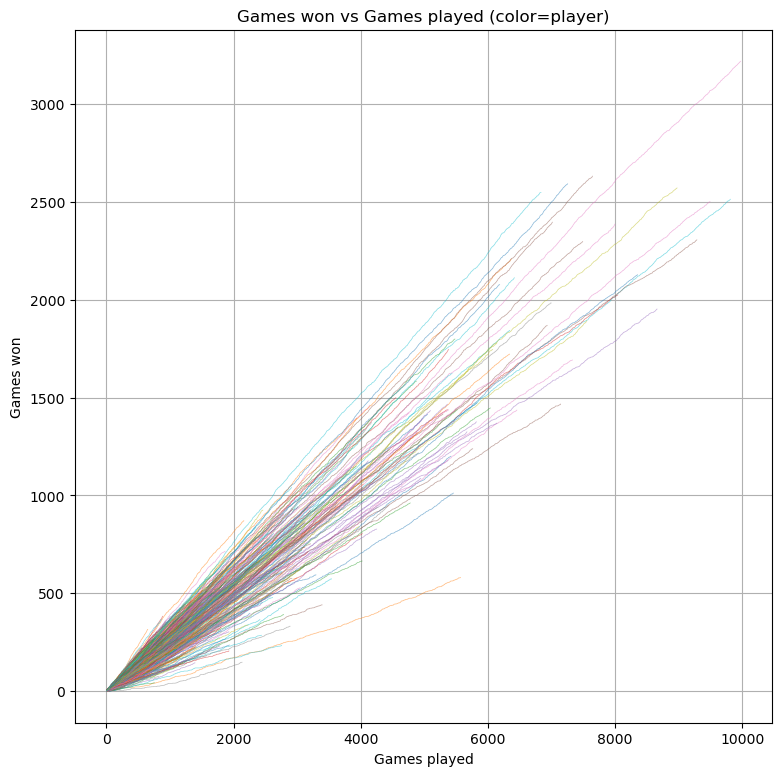

In [31]:
fig0 = plt.figure(figsize=(9,9))

for p in player_factors.keys():
    data = player_factors[p]['won_so_far']
    
    x = range(len(data))
    y = data
    plt.plot(x,y, linewidth=0.5, alpha=0.5)

# plt.ylim((0.0, 0.5))
plt.grid()
plt.xlabel('Games played');
plt.ylabel('Games won');
plt.title('Games won vs Games played (color=player)');
plt.savefig('./figures/won_vs_played.png')
plt.show()

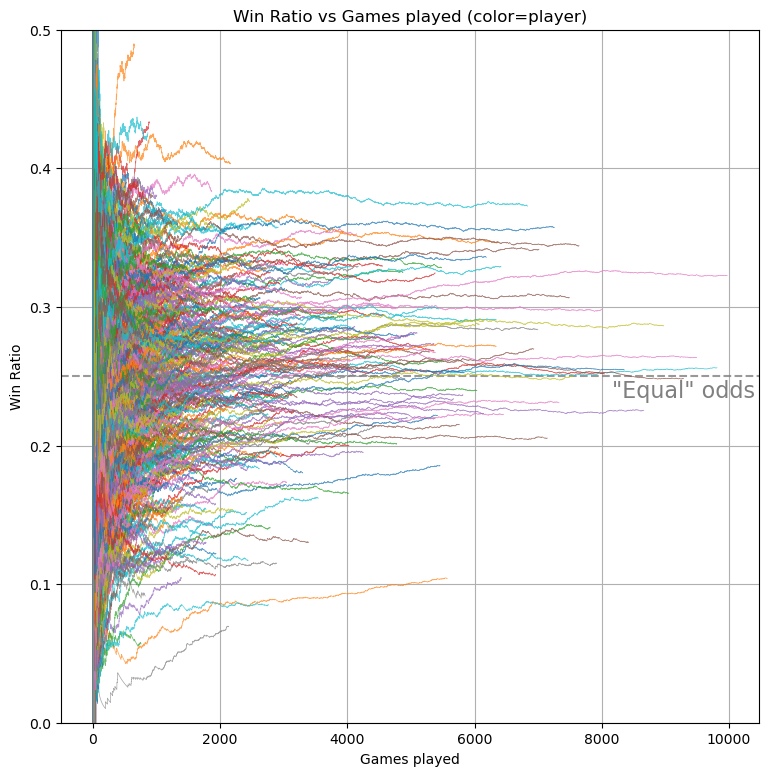

In [84]:
fig1 = plt.figure(figsize=(9,9))
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.8)

# ps = pd.Series(player_factors.keys()).sample(88)
# for p in ps:
for p in player_factors.keys():
    data = player_factors[p]['running_win_ratio']
    alphas = np.linspace(0.1, 0.7, len(data))
    x = range(len(data))
    y = data
    plt.plot(x,y, linewidth=0.5, alpha=0.7)

plt.ylim((0.0, 0.5))
x_label_pos = fig1.axes[0].get_xlim()[1]*0.78
plt.text(x_label_pos, 0.235, '"Equal" odds', fontsize = 16, color='grey')
plt.grid()
plt.xlabel('Games played');
plt.ylabel('Win Ratio');
plt.title('Win Ratio vs Games played (color=player)');
fig1.savefig('./figures/ratio_vs_played.png')
plt.show()

In [33]:
rows = []
for p in player_factors.keys():
    all_points = player_factors[p]['running_win_ratio'][1:]
    
    y = np.array(all_points).reshape(-1,1)
    x = np.array(range(len(y)))
    
    lm = LinearRegression()
    lm.fit(y, x)
    rows.append({'id': p,
                 'intercept': lm.intercept_,
                 'slope': lm.coef_[0]})

In [34]:
betas = pd.DataFrame(rows)
betas

,id,intercept,slope
0,22,-1639.242730,11987.710606
1,36,2658.123504,-6445.227643
2,120,313.558773,1459.639695
3,119,1203.353406,-2950.472370
4,70,-698.326231,4364.115773
...,...,...,...
596,11475,-40.090632,2942.431721
597,32709,393.740369,290.557862
598,32714,525.173332,-698.533325
599,32800,1165.564907,-2419.374924


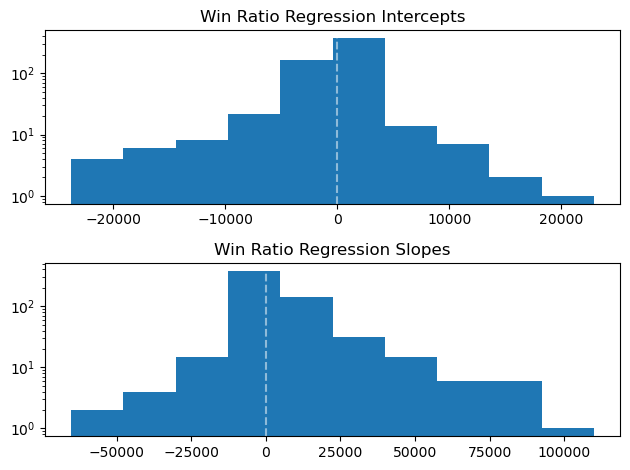

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1)

ax0, ax1 = axes.flatten()

ax0.hist(betas.intercept, log=True)
ax0.set_title('Win Ratio Regression Intercepts')
ax0.axvline(x=0, color='w', linestyle='--', alpha=0.5)
ax1.hist(betas.slope, log=True)
ax1.set_title('Win Ratio Regression Slopes')
ax1.axvline(x=0, color='w', linestyle='--', alpha=0.5)

fig.tight_layout()

plt.savefig('./figures/betas_hists.png')
plt.show()

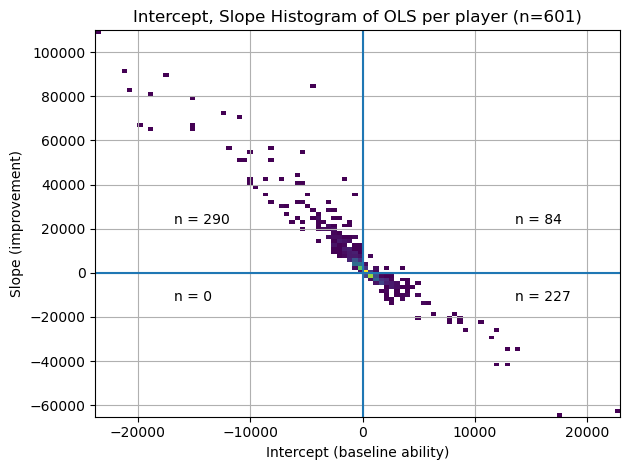

In [36]:
plt.hist2d(betas.intercept, betas.slope, bins=100, cmin=1)
plt.axvline(x=0)
plt.axhline(y=0)
plt.annotate("n = 84",  xy=(0.8,  0.5), xycoords="axes fraction")
plt.annotate("n = 227", xy=(0.8,  0.3), xycoords="axes fraction")
plt.annotate("n = 290", xy=(0.15, 0.5), xycoords="axes fraction")
plt.annotate("n = 0",   xy=(0.15, 0.3), xycoords="axes fraction")
plt.title('Intercept, Slope Histogram of OLS per player (n=601)')
plt.xlabel('Intercept (baseline ability)')
plt.ylabel('Slope (improvement)')
plt.grid();
plt.tight_layout();
plt.savefig('./figures/2D_regression_hist.png')

In [37]:
# upper-right, started good, got better
sum((betas.intercept > 0) & (betas.slope > 0))

84

In [38]:
# lower-right, started good, got worse
sum((betas.intercept > 0) & (betas.slope < 0))

227

In [39]:
# upper-left, started bad, got better
sum((betas.intercept < 0) & (betas.slope > 0))

290

In [40]:
# lower-left, started bad, got worse
sum((betas.intercept < 0) & (betas.slope < 0))

0

## MODELING BASED ON PLAY-COUNT

In [41]:
df_pc = games.copy()

In [42]:
y = df_pc.winning_player
X = df_pc[player_cols]

In [43]:
Xtrain, _, _, _ = train_test_split(X, y, shuffle=False)

In [44]:
train_counts_dict = Counter(Xtrain.values.flatten())
train_counts_dict[36]

1927

In [45]:
sum(df_pc['player1'] == 0)

0

In [46]:
df_pc['player1'] = df_pc['player1'].map(train_counts_dict)
df_pc['player2'] = df_pc['player2'].map(train_counts_dict)
df_pc['player3'] = df_pc['player3'].map(train_counts_dict)
df_pc['player4'] = df_pc['player4'].map(train_counts_dict)

In [47]:
sum(df_pc['player1'] == 0)

26332

In [48]:
df_pc['player1'].isna().sum()

0

We have to re-split now that we have substituted playerID for play_count.

In [49]:
y = df_pc.winning_player
X = df_pc[player_cols]

In [50]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=False)

array([[<AxesSubplot:title={'center':'player1'}>,
        <AxesSubplot:title={'center':'player2'}>],
       [<AxesSubplot:title={'center':'player3'}>,
        <AxesSubplot:title={'center':'player4'}>]], dtype=object)

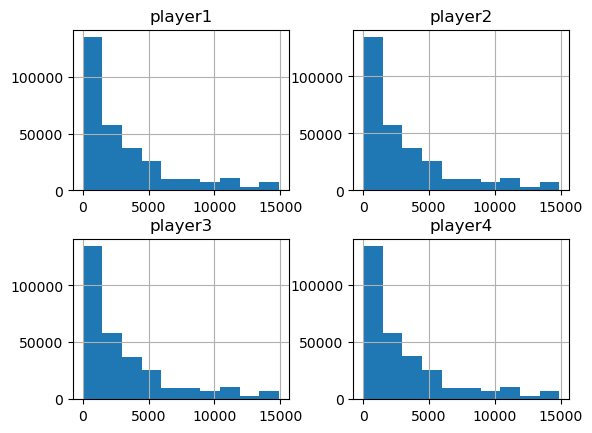

In [51]:
Xtrain.hist()

In [52]:
Xtrain.sample(15)

,player1,player2,player3,player4
214111,617,4253,442,127
89164,9974,1422,9723,392
1777,2479,823,653,561
273032,273,907,3115,429
171957,322,9225,1120,1357
179019,3908,3487,8705,4548
177722,1029,1660,13192,2959
196699,2,8,2029,14
188198,256,577,454,603
115694,4118,818,5757,506


In [53]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Xtrain, ytrain)
knn.score(Xtest, ytest)

0.2646622783609085

In [54]:
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
gnb.score(Xtest, ytest)

0.27869694992982663

In [55]:
ytrain = ytrain - 1
ytest = ytest - 1

In [56]:
boost = XGBClassifier(n_estimators=5, objective='multi:softmax')
boost.fit(Xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [57]:
ypred = boost.predict(Xtest)

In [58]:
boost.score(Xtest, ytest)

0.28329281069007095

## MODELING BASED ON WIN RATIO

In [59]:
df_wr = games.copy()

In [60]:
y = df_wr.winning_player
X = df_wr

In [61]:
Xtrain, _, _, _ = train_test_split(X, y, shuffle=False)

In [62]:
Xtrain

,timestamp,player1,player2,player3,player4,score1,score2,score3,score4,winning_score,winning_player,winner_id
0,1408990866000,7,12,10,6,262,459,406,409,459,2,12
1,1408994459000,6,12,10,7,524,419,195,402,524,1,6
2,1408998197000,7,10,6,12,308,353,467,497,497,4,12
3,1409002158000,12,7,10,6,500,525,256,261,525,2,7
4,1409600757000,10,6,23,7,383,375,228,242,383,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...
303529,1633918192942,6211,28051,43,14777,459,135,624,324,624,3,43
303530,1633918611040,18210,709,20769,22438,380,406,364,468,468,4,22438
303531,1633918701533,27235,27476,27236,27542,399,370,310,490,490,4,27542
303532,1633919246327,3927,6211,17391,12428,350,529,367,336,529,2,6211


In [63]:
train_players = Xtrain.winner_id.unique()

In [64]:
train_win_counts_dict = Counter(Xtrain.winner_id)
train_win_counts = pd.DataFrame.from_dict(win_counts_dict, orient='index', columns=['won_games'])

In [65]:
train_play_counts_dict = Counter(games[player_cols].values.flatten())
train_play_counts = pd.DataFrame.from_dict(train_play_counts_dict, orient='index', columns=['played_games'])
train_play_counts.index.name = 'player_id'
train_play_counts

,played_games
player_id,
7,370
12,375
10,148
6,290
23,175
...,...
33558,2
16990,3
33574,2


In [66]:
train_win_ratio_dict = {player: (train_win_counts_dict[player]/play_counts_dict[player]) for player in train_players}

In [67]:
train_win_ratio_dict

{12: 0.20266666666666666,
 6: 0.20344827586206896,
 7: 0.25135135135135134,
 10: 0.1891891891891892,
 20: 1.0,
 36: 0.2516865594187857,
 22: 0.2470967741935484,
 120: 0.20853080568720378,
 119: 0.23108808290155441,
 16: 0.28424444570071794,
 1: 0.3572607260726073,
 208: 0.30681133212778783,
 207: 0.32731293770733505,
 200: 0.32471794871794873,
 178: 0.35294117647058826,
 238: 0.2549019607843137,
 43: 0.31485717637398086,
 226: 0.15384615384615385,
 157: 0.2219804134929271,
 73: 0.2535211267605634,
 212: 0.34539473684210525,
 198: 0.37601626016260165,
 167: 0.16666666666666666,
 165: 0.5,
 262: 0.21580547112462006,
 70: 0.26367461430575034,
 182: 0.25,
 206: 0.23913518235422582,
 47: 0.23348017621145375,
 183: 0.1111111111111111,
 240: 0.29546758462421113,
 233: 0.36363636363636365,
 250: 0.3066346282205313,
 38: 0.23929471032745592,
 247: 0.28205128205128205,
 276: 0.263782866836302,
 72: 0.2668189895912668,
 190: 0.230989136649514,
 273: 0.22791243158717747,
 215: 0.2813067150635209,


In [68]:
df_wr['player1'] = df_wr['player1'].map(train_win_ratio_dict)
df_wr['player2'] = df_wr['player2'].map(train_win_ratio_dict)
df_wr['player3'] = df_wr['player3'].map(train_win_ratio_dict)
df_wr['player4'] = df_wr['player4'].map(train_win_ratio_dict)

We have to re-split now that we have substituted playerID for play_count.

In [69]:
df_wr.isna().sum().sum()

124730

In [70]:
df_wr = df_wr.fillna(0)

In [71]:
df_wr.isna().sum().sum()

0

In [72]:
y = df_wr.winning_player
X = df_wr[player_cols]

In [73]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=False)

In [74]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Xtrain, ytrain)
knn.score(Xtest, ytest)

0.27885508707426515

In [75]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(Xtrain, ytrain)
knn.score(Xtest, ytest)

0.30085591729427347

In [76]:
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
gnb.score(Xtest, ytest)

0.3050663187649489

In [77]:
ytrain = ytrain - 1
ytest = ytest - 1

In [78]:
boost = XGBClassifier(n_estimators=5, objective='multi:softmax')
boost.fit(Xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [79]:
ypred = boost.predict(Xtest)

In [80]:
boost.score(Xtest, ytest)

0.30209136373519935